In [ ]:
# This work uses the db: https://www.kaggle.com/binaryjoker/airline-passenger-satisfaction

# Installing Pycaret

In [ ]:
!pip install pycaret['full']

     |████████████████████████████████| 266kB 11.4MB/s 
     |████████████████████████████████| 6.8MB 37.8MB/s 
     |████████████████████████████████| 81kB 4.7MB/s 
     |████████████████████████████████| 1.7MB 35.3MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 174kB 44.2MB/s 
     |████████████████████████████████| 61kB 6.4MB/s 
     |████████████████████████████████| 112kB 44.4MB/s 
     |████████████████████████████████| 14.2MB 218kB/s 
     |████████████████████████████████| 1.4MB 35.3MB/s 
     |████████████████████████████████| 2.0MB 41.2MB/s 
     |████████████████████████████████| 276kB 47.4MB/s 
     |████████████████████████████████| 256kB 45.3MB/s 
     |████████████████████████████████| 348kB 41.1MB/s 
     |████████████████████████████████| 51.6MB 129kB/s 
     |████████████████████████████████| 40kB 5.1MB/

In [ ]:
!pip install dask --upgrade

     |████████████████████████████████| 983kB 14.9MB/s 
     |████████████████████████████████| 122kB 31.2MB/s 
  Found existing installation: dask 2.12.0
    Uninstalling dask-2.12.0:
      Successfully uninstalled dask-2.12.0


In [ ]:
!pip install dask_ml

     |████████████████████████████████| 143kB 13.9MB/s 
     |████████████████████████████████| 727kB 25.8MB/s 
ERROR: distributed 2021.6.2 has requirement cloudpickle>=1.5.0, but you'll have cloudpickle 1.3.0 which is incompatible.
  Found existing installation: distributed 1.25.3
    Uninstalling distributed-1.25.3:
      Successfully uninstalled distributed-1.25.3


In [ ]:
# Still needed
from pycaret.utils import enable_colab

enable_colab()

Colab mode enabled.


# Loading dataset

The DB can be found using the URL: https://www.kaggle.com/binaryjoker/airline-passenger-satisfaction

Te aim is to classify, using certain parameters, wether the person is satisfied with the airline or not

In [ ]:
# Importing libraries and uploading data from local machine
import dask.dataframe as dd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

files.upload()  
dataset = dd.read_csv('airline_passenger_satisfaction.csv')

Saving airline_passenger_satisfaction.csv to airline_passenger_satisfaction.csv


In [ ]:
# We drop half of the samples in order to do it less computationally heavy
dataset = dataset.sample(frac=0.15, random_state=786)
dataset.compute().reset_index(inplace=True, drop=True)

In [ ]:
# Seek dataset
dataset.head(5)
dataset.drop(['type_of_travel'], axis=1)

Dask DataFrame Structure:
              Unnamed: 0  Gender customer_type    age customer_class flight_distance inflight_wifi_service departure_arrival_time_convenient ease_of_online_booking gate_location food_and_drink online_boarding seat_comfort inflight_entertainment onboard_service leg_room_service baggage_handling checkin_service inflight_service cleanliness departure_delay_in_minutes arrival_delay_in_minutes satisfaction
npartitions=1                                                                                                                                                                                                                                                                                                                                                                                                       
                   int64  object        object  int64         object           int64                 int64                             int64                  int64         int64          int64           int64        int64                  int64           int64            int64            int64           int64            int64       int64                      int64                  float64       object
                     ...     ...           ...    ...            ...             ...                   ...                               ...                    ...           ...            ...             ...          ...                    ...             ...              ...              ...             ...              ...         ...                        ...                      ...          ...
Dask Name: drop_by_shallow_copy, 3 tasks

In [ ]:
result = dataset.categorize(columns = ['Gender', 'customer_type', 'type_of_travel', 'satisfaction', 'customer_class'])
data1 = dd.get_dummies(result['Gender'], prefix='G')
data2 = dd.get_dummies(result['customer_type'], prefix='CT')
data3 = dd.get_dummies(result['type_of_travel'], prefix='TT')
data4 = dd.get_dummies(result['satisfaction'], prefix='S')


data5 = result.drop(['Gender', 'customer_type', 'type_of_travel', 'satisfaction'], axis=1)
data5 = dd.concat([data5, data1, data2, data3, data4], axis=1)
data5.head()

/usr/local/lib/python3.7/dist-packages/dask/dataframe/multi.py:1197: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indices of each dataframes are 
 aligned. This assumption is not generally safe.
  "Concatenating dataframes with unknown divisions.\n"


Unnamed: 0  age  ... S_neutral or dissatisfied  S_satisfied
22536        22536   52  ...                         1            0
88666        88666   64  ...                         1            0
111226      111226   60  ...                         0            1
62767        62767   30  ...                         0            1
83495        83495   36  ...                         1            0

[5 rows x 28 columns]

In [ ]:
from dask_ml.preprocessing import LabelEncoder

le = LabelEncoder()
clase = le.fit_transform(result['customer_class'])
result=clase.compute()

In [ ]:
data6 = data5.drop(['customer_class'], axis=1)

darr = dd.from_array(result)
darr.name = 'customer_class'
darr_frame=darr.to_frame()

data = dd.concat([data6.compute(), darr_frame.compute()], axis=1)
# data2.add(darr.compute(), axis = 1)

In [ ]:
data.head(5)

Unnamed: 0  age  ...  S_satisfied  customer_class
6            6   47  ...            0               0
7            7   52  ...            1               1
9            9   20  ...            0               0
11          11   12  ...            0               2
13          13   33  ...            1               0

[5 rows x 28 columns]

In [ ]:
dataset_final=data.drop(data.columns[25], axis=1)
dataset_final.head(5)

Unnamed: 0  age  ...  S_satisfied  customer_class
6            6   47  ...            0               0
7            7   52  ...            1               1
9            9   20  ...            0               0
11          11   12  ...            0               2
13          13   33  ...            1               0

[5 rows x 27 columns]

In [ ]:
type(dataset_final.compute())

pandas.core.frame.DataFrame

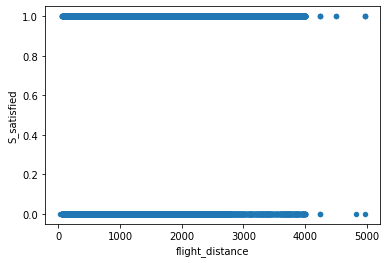

In [ ]:
import matplotlib.pyplot as plt

dataset_final.compute().plot(kind="scatter", x="flight_distance", y="S_satisfied")

# Training and validation

In [ ]:
data = dataset_final.sample(frac=0.85, random_state=786)
data_unseen = dataset_final.compute().drop(data.index)
data.compute().reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)
print('Data for training and validation: ' + str(data.shape))
print('Unseen data for testing: ' + str(data_unseen.shape))

Data for training and validation: (Delayed('int-38ed8624-217a-442d-be35-32333876fe14'), 27)
Unseen data for testing: (2922, 27)


In [ ]:
# Data preprocessing
from pycaret.classification import * 
exp_clf = setup(data.compute(), target = 'S_satisfied',
                normalize = True,
                transformation = True,
                train_size = 0.8)

Description             Value
0                               session_id              5786
1                                   Target       S_satisfied
2                              Target Type            Binary
3                            Label Encoded              None
4                            Original Data       (16560, 27)
5                           Missing Values              True
6                         Numeric Features                12
7                     Categorical Features                14
8                         Ordinal Features             False
9                High Cardinality Features             False
10                 High Cardinality Method              None
11                   Transformed Train Set       (13248, 86)
12                    Transformed Test Set        (3312, 86)
13                      Shuffle Train-Test              True
14                     Stratify Train-Test             False
15                          Fold Generator   StratifiedKFold
16                             Fold Number                10
17                                CPU Jobs                -1
18                                 Use GPU             False
19                          Log Experiment             False
20                         Experiment Name  clf-default-name
21                                     USI              ee3a
22                         Imputation Type            simple
23          Iterative Imputation Iteration              None
24                         Numeric Imputer              mean
25      Iterative Imputation Numeric Model              None
26                     Categorical Imputer          constant
27  Iterative Imputation Categorical Model              None
28           Unknown Categoricals Handling    least_frequent
29                               Normalize              True
30                        Normalize Method            zscore
31                          Transformation              True
32                   Transformation Method       yeo-johnson
33                                     PCA             False
34                              PCA Method              None
35                          PCA Components              None
36                     Ignore Low Variance             False
37                     Combine Rare Levels             False
38                    Rare Level Threshold              None
39                         Numeric Binning             False
40                         Remove Outliers             False
41                      Outliers Threshold              None
42                Remove Multicollinearity             False
43             Multicollinearity Threshold              None
44             Remove Perfect Collinearity              True
45                              Clustering             False
46                    Clustering Iteration              None
47                     Polynomial Features             False
48                       Polynomial Degree              None
49                    Trignometry Features             False
50                    Polynomial Threshold              None
51                          Group Features             False
52                       Feature Selection             False
53                Feature Selection Method           classic
54            Features Selection Threshold              None
55                     Feature Interaction             False
56                           Feature Ratio             False
57                   Interaction Threshold              None
58                           Fix Imbalance             False
59                    Fix Imbalance Method             SMOTE

In [ ]:
# We get the 5 top models
top5 = compare_models(cross_validation=True, fold=5, n_select=5)

Model  Accuracy     AUC  Recall   Prec.  \
catboost              CatBoost Classifier    0.9579  0.9926  0.9373  0.9653   
lightgbm  Light Gradient Boosting Machine    0.9576  0.9930  0.9342  0.9676   
xgboost         Extreme Gradient Boosting    0.9549  0.9920  0.9359  0.9600   
et                 Extra Trees Classifier    0.9525  0.9903  0.9271  0.9629   
rf               Random Forest Classifier    0.9501  0.9899  0.9231  0.9612   
gbc          Gradient Boosting Classifier    0.9444  0.9877  0.9188  0.9524   
svm                   SVM - Linear Kernel    0.9309  0.0000  0.9090  0.9315   
lr                    Logistic Regression    0.9307  0.9782  0.9109  0.9292   
ridge                    Ridge Classifier    0.9284  0.0000  0.9033  0.9310   
lda          Linear Discriminant Analysis    0.9283  0.9751  0.9033  0.9306   
dt               Decision Tree Classifier    0.9267  0.9256  0.9168  0.9157   
ada                  Ada Boost Classifier    0.9236  0.9760  0.9052  0.9189   
knn                K Neighbors Classifier    0.9068  0.9603  0.8945  0.8925   
nb                            Naive Bayes    0.8659  0.9400  0.8644  0.8360   
qda       Quadratic Discriminant Analysis    0.5947  0.5681  0.3570  0.5632   

              F1   Kappa     MCC  TT (Sec)  
catboost  0.9511  0.9141  0.9144    11.376  
lightgbm  0.9506  0.9135  0.9139     0.488  
xgboost   0.9478  0.9082  0.9084     9.378  
et        0.9446  0.9031  0.9036     1.514  
rf        0.9418  0.8982  0.8987     1.558  
gbc       0.9353  0.8867  0.8871     2.822  
svm       0.9200  0.8593  0.8596     0.160  
lr        0.9199  0.8589  0.8590     1.078  
ridge     0.9169  0.8541  0.8544     0.070  
lda       0.9167  0.8538  0.8541     0.248  
dt        0.9162  0.8511  0.8511     0.154  
ada       0.9120  0.8445  0.8446     0.804  
knn       0.8935  0.8106  0.8106    10.264  
nb        0.8492  0.7286  0.7300     0.070  
qda       0.4114  0.1400  0.1550     0.162

We will optimize the MCC, since it is the one that is giving us the best results from the point of view of the confussion matrix. After that, we will use a model calibration in order to get a better classifier.


In [ ]:
tuned_m1 = tune_model(top5[0], optimize = 'MCC', verbose = False)
calibrated_m1 = calibrate_model(tuned_m1, method = 'isotonic')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.9570  0.9941  0.9344  0.9661  0.9500  0.9123  0.9126
1       0.9660  0.9957  0.9465  0.9751  0.9606  0.9308  0.9311
2       0.9457  0.9885  0.9119  0.9617  0.9362  0.8889  0.8899
3       0.9608  0.9939  0.9447  0.9647  0.9546  0.9201  0.9202
4       0.9532  0.9925  0.9309  0.9608  0.9456  0.9046  0.9049
5       0.9562  0.9912  0.9396  0.9594  0.9494  0.9108  0.9110
6       0.9555  0.9934  0.9292  0.9676  0.9480  0.9091  0.9097
7       0.9600  0.9918  0.9292  0.9782  0.9531  0.9183  0.9192
8       0.9547  0.9937  0.9223  0.9727  0.9468  0.9074  0.9084
9       0.9653  0.9934  0.9482  0.9717  0.9598  0.9292  0.9294
Mean    0.9574  0.9928  0.9337  0.9678  0.9504  0.9131  0.9136
SD      0.0057  0.0019  0.0109  0.0061  0.0068  0.0117  0.0115

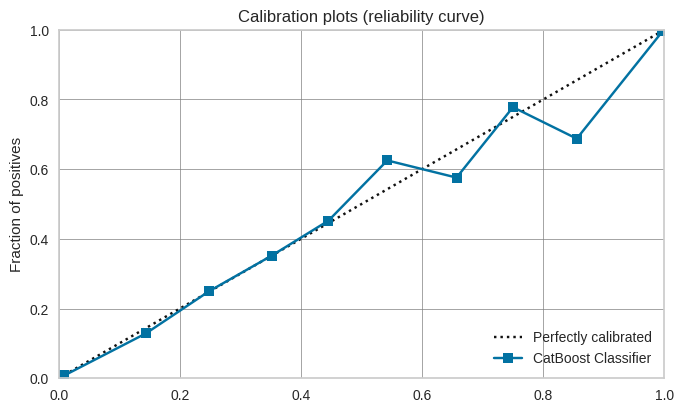

In [ ]:
plot_model(calibrated_m1, plot='calibration')

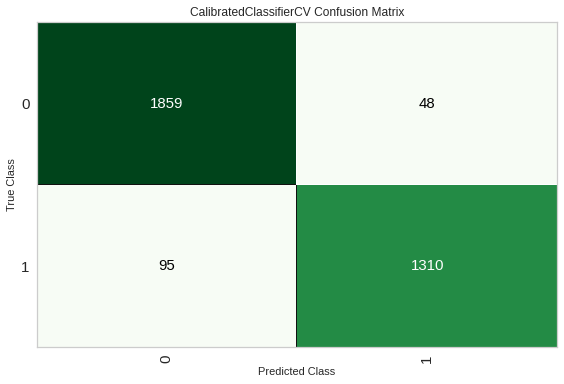

In [ ]:
plot_model(calibrated_m1, plot='confusion_matrix')

In [ ]:
tuned_m2 = tune_model(top5[1], optimize = 'MCC', verbose= False)
calibrated_m2 = calibrate_model(tuned_m2, method = 'isotonic')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.9547  0.9918  0.9326  0.9626  0.9474  0.9077  0.9080
1       0.9577  0.9940  0.9413  0.9612  0.9511  0.9139  0.9141
2       0.9389  0.9871  0.9085  0.9495  0.9285  0.8752  0.8758
3       0.9517  0.9909  0.9275  0.9606  0.9438  0.9015  0.9019
4       0.9457  0.9903  0.9188  0.9551  0.9366  0.8891  0.8896
5       0.9449  0.9893  0.9257  0.9470  0.9362  0.8878  0.8879
6       0.9517  0.9916  0.9275  0.9606  0.9438  0.9015  0.9019
7       0.9525  0.9899  0.9171  0.9725  0.9440  0.9028  0.9039
8       0.9569  0.9932  0.9257  0.9745  0.9495  0.9120  0.9129
9       0.9585  0.9912  0.9396  0.9645  0.9519  0.9153  0.9156
Mean    0.9513  0.9909  0.9264  0.9608  0.9433  0.9007  0.9012
SD      0.0060  0.0019  0.0095  0.0083  0.0071  0.0124  0.0123

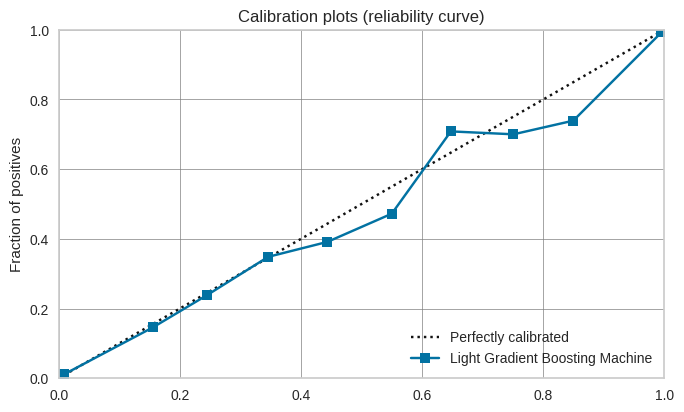

In [ ]:
plot_model(calibrated_m2, plot='calibration')

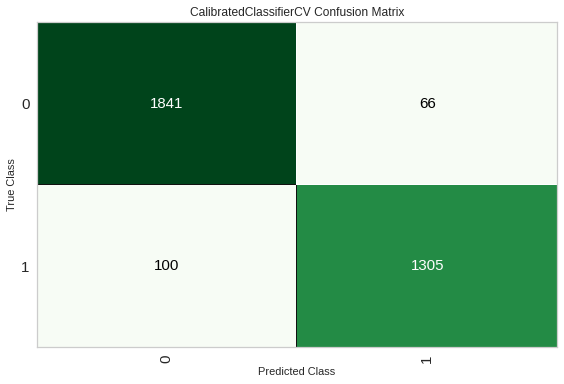

In [ ]:
plot_model(calibrated_m2, plot='confusion_matrix')

In [ ]:
tuned_m3 = tune_model(top5[2], optimize = 'MCC', verbose=False)
calibrated_m3=calibrate_model(tuned_m3, method='isotonic')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.9645  0.9941  0.9465  0.9716  0.9589  0.9277  0.9279
1       0.9653  0.9960  0.9430  0.9767  0.9596  0.9292  0.9296
2       0.9479  0.9884  0.9136  0.9653  0.9388  0.8935  0.8946
3       0.9592  0.9937  0.9361  0.9696  0.9525  0.9169  0.9173
4       0.9577  0.9921  0.9344  0.9678  0.9508  0.9138  0.9142
5       0.9562  0.9914  0.9326  0.9660  0.9490  0.9107  0.9111
6       0.9555  0.9931  0.9292  0.9676  0.9480  0.9091  0.9097
7       0.9577  0.9915  0.9275  0.9746  0.9504  0.9136  0.9145
8       0.9645  0.9945  0.9396  0.9784  0.9586  0.9275  0.9281
9       0.9615  0.9931  0.9447  0.9664  0.9555  0.9215  0.9217
Mean    0.9590  0.9928  0.9347  0.9704  0.9522  0.9164  0.9169
SD      0.0050  0.0020  0.0093  0.0045  0.0060  0.0103  0.0102

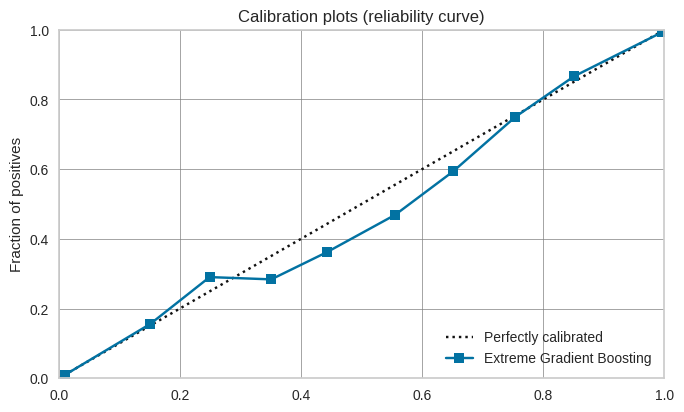

In [ ]:
plot_model(calibrated_m3, plot='calibration')

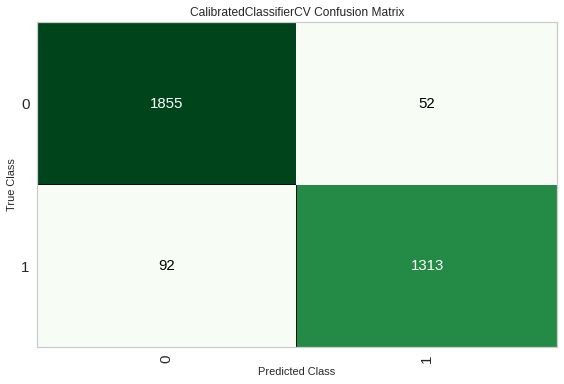

In [ ]:
plot_model(calibrated_m3, plot='confusion_matrix')

In [ ]:
tuned_m4 = tune_model(top5[3], optimize = 'MCC', verbose=False)
calibrated_m4=calibrate_model(tuned_m3, method='isotonic')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.9645  0.9941  0.9465  0.9716  0.9589  0.9277  0.9279
1       0.9653  0.9960  0.9430  0.9767  0.9596  0.9292  0.9296
2       0.9479  0.9884  0.9136  0.9653  0.9388  0.8935  0.8946
3       0.9592  0.9937  0.9361  0.9696  0.9525  0.9169  0.9173
4       0.9577  0.9921  0.9344  0.9678  0.9508  0.9138  0.9142
5       0.9562  0.9914  0.9326  0.9660  0.9490  0.9107  0.9111
6       0.9555  0.9931  0.9292  0.9676  0.9480  0.9091  0.9097
7       0.9577  0.9915  0.9275  0.9746  0.9504  0.9136  0.9145
8       0.9645  0.9945  0.9396  0.9784  0.9586  0.9275  0.9281
9       0.9615  0.9931  0.9447  0.9664  0.9555  0.9215  0.9217
Mean    0.9590  0.9928  0.9347  0.9704  0.9522  0.9164  0.9169
SD      0.0050  0.0020  0.0093  0.0045  0.0060  0.0103  0.0102

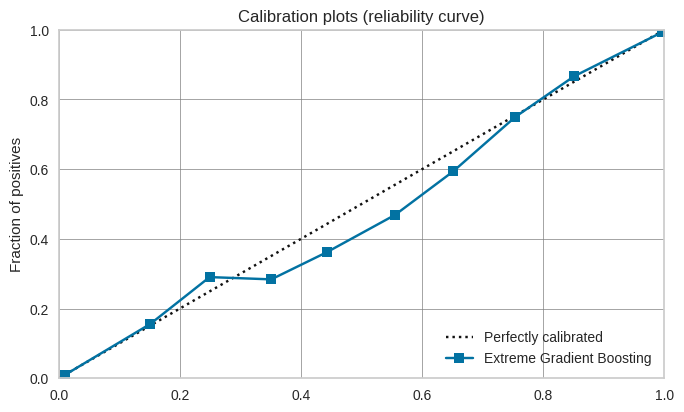

In [ ]:
plot_model(calibrated_m4, plot='calibration')

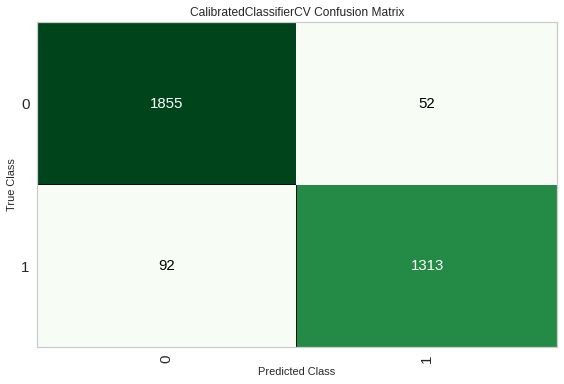

In [ ]:
plot_model(calibrated_m4, plot='confusion_matrix')

In [ ]:
tuned_m5 = tune_model(top5[4], optimize = 'MCC', verbose=False)
calibrated_m5=calibrate_model(tuned_m3, method='isotonic')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.9645  0.9941  0.9465  0.9716  0.9589  0.9277  0.9279
1       0.9653  0.9960  0.9430  0.9767  0.9596  0.9292  0.9296
2       0.9479  0.9884  0.9136  0.9653  0.9388  0.8935  0.8946
3       0.9592  0.9937  0.9361  0.9696  0.9525  0.9169  0.9173
4       0.9577  0.9921  0.9344  0.9678  0.9508  0.9138  0.9142
5       0.9562  0.9914  0.9326  0.9660  0.9490  0.9107  0.9111
6       0.9555  0.9931  0.9292  0.9676  0.9480  0.9091  0.9097
7       0.9577  0.9915  0.9275  0.9746  0.9504  0.9136  0.9145
8       0.9645  0.9945  0.9396  0.9784  0.9586  0.9275  0.9281
9       0.9615  0.9931  0.9447  0.9664  0.9555  0.9215  0.9217
Mean    0.9590  0.9928  0.9347  0.9704  0.9522  0.9164  0.9169
SD      0.0050  0.0020  0.0093  0.0045  0.0060  0.0103  0.0102

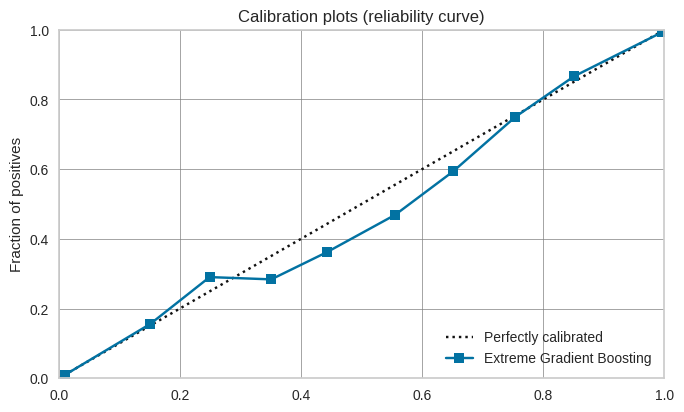

In [ ]:
plot_model(calibrated_m5, plot='calibration')

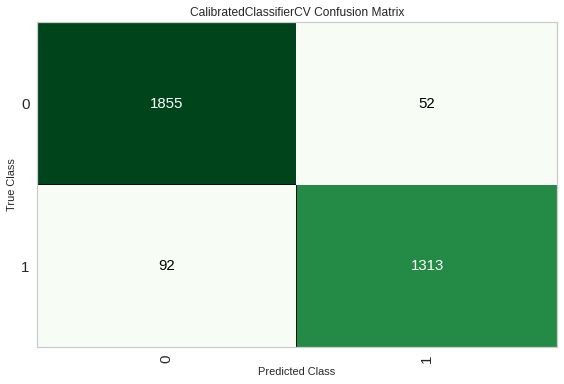

In [ ]:
plot_model(calibrated_m5, 'confusion_matrix')

# Model mix


The idea is to combine the best model using different tecniques in order to get a more robust model

In [ ]:
#Bagging
bagged_m2 = ensemble_model(top5[0])

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.9608  0.9942  0.9378  0.9714  0.9543  0.9199  0.9204
1       0.9691  0.9961  0.9551  0.9736  0.9643  0.9370  0.9371
2       0.9449  0.9887  0.9206  0.9518  0.9359  0.8876  0.8880
3       0.9592  0.9935  0.9396  0.9663  0.9527  0.9169  0.9172
4       0.9509  0.9926  0.9326  0.9541  0.9432  0.9001  0.9002
5       0.9555  0.9906  0.9344  0.9626  0.9483  0.9092  0.9095
6       0.9585  0.9933  0.9344  0.9695  0.9516  0.9153  0.9158
7       0.9532  0.9912  0.9188  0.9726  0.9449  0.9043  0.9054
8       0.9577  0.9942  0.9275  0.9746  0.9504  0.9136  0.9144
9       0.9615  0.9934  0.9482  0.9632  0.9556  0.9216  0.9217
Mean    0.9571  0.9928  0.9349  0.9660  0.9501  0.9126  0.9130
SD      0.0062  0.0020  0.0107  0.0076  0.0073  0.0127  0.0126

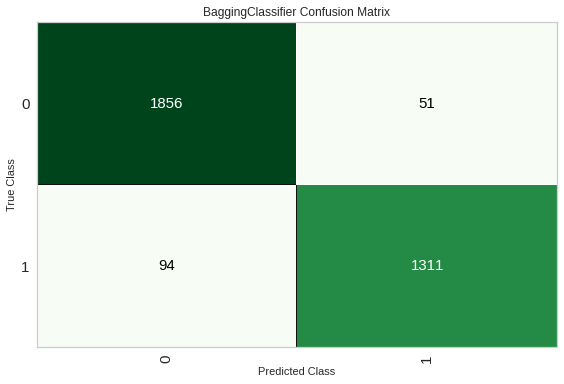

In [ ]:
plot_model(bagged_m2, 'confusion_matrix')

In [ ]:
#blending
blend_hard = blend_models(estimator_list = [top5[0], top5[1], top5[2], top5[3], top5[4]], method = 'hard')

Accuracy  AUC  Recall   Prec.      F1   Kappa     MCC
0       0.9623  0.0  0.9396  0.9732  0.9561  0.9230  0.9235
1       0.9698  0.0  0.9534  0.9770  0.9650  0.9385  0.9387
2       0.9487  0.0  0.9206  0.9604  0.9400  0.8952  0.8958
3       0.9570  0.0  0.9344  0.9661  0.9500  0.9123  0.9126
4       0.9517  0.0  0.9292  0.9590  0.9439  0.9015  0.9018
5       0.9555  0.0  0.9326  0.9643  0.9482  0.9092  0.9096
6       0.9570  0.0  0.9292  0.9711  0.9497  0.9121  0.9128
7       0.9570  0.0  0.9223  0.9780  0.9493  0.9120  0.9132
8       0.9577  0.0  0.9275  0.9746  0.9504  0.9136  0.9144
9       0.9622  0.0  0.9499  0.9632  0.9565  0.9231  0.9232
Mean    0.9579  0.0  0.9339  0.9687  0.9509  0.9141  0.9146
SD      0.0056  0.0  0.0103  0.0066  0.0066  0.0114  0.0113

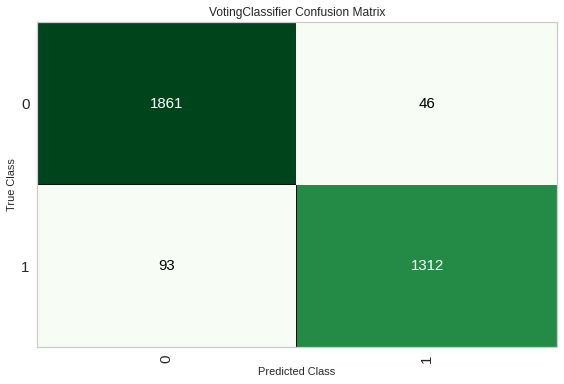

In [ ]:
plot_model(blend_hard, 'confusion_matrix')

In [ ]:
# Stacking
stacked=stack_models(estimator_list = [top5[1], top5[2], top5[3], top5[4]], meta_model = top5[0])

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.9668  0.9949  0.9396  0.9837  0.9611  0.9322  0.9329
1       0.9706  0.9964  0.9534  0.9787  0.9659  0.9400  0.9403
2       0.9419  0.9889  0.9085  0.9564  0.9318  0.8812  0.8821
3       0.9570  0.9940  0.9344  0.9661  0.9500  0.9123  0.9126
4       0.9615  0.9936  0.9413  0.9698  0.9553  0.9215  0.9218
5       0.9585  0.9929  0.9447  0.9596  0.9521  0.9155  0.9156
6       0.9592  0.9937  0.9378  0.9679  0.9526  0.9169  0.9172
7       0.9577  0.9921  0.9275  0.9746  0.9504  0.9136  0.9145
8       0.9607  0.9956  0.9361  0.9731  0.9542  0.9199  0.9204
9       0.9600  0.9935  0.9465  0.9614  0.9539  0.9185  0.9186
Mean    0.9594  0.9936  0.9370  0.9691  0.9527  0.9172  0.9176
SD      0.0071  0.0020  0.0116  0.0082  0.0084  0.0145  0.0144

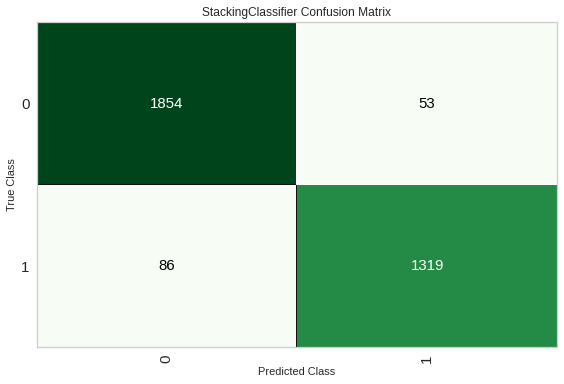

In [ ]:
plot_model(stacked, 'confusion_matrix')

# Testing

We need to finalize the model before testing it

In [ ]:
modelo = finalize_model(stacked)

In [ ]:
dataset_2 = data_unseen.drop(['S_satisfied'], axis=1)

In [ ]:
predictions = predict_model(modelo, data = dataset_2)
predictions

Unnamed: 0  age  flight_distance  ...  customer_class  Label   Score
0              7   52             2035  ...               1      1  0.9996
1            138   67             2659  ...               1      0  0.9968
2            145   68              480  ...               0      0  0.9998
3            179   52             2768  ...               1      0  0.8007
4            191   12              462  ...               0      0  0.9993
...          ...  ...              ...  ...             ...    ...     ...
2917      129651   50             2440  ...               1      1  1.0000
2918      129684   22              912  ...               1      1  0.9741
2919      129708   43              226  ...               0      0  0.9971
2920      129745   27             2157  ...               1      1  0.9995
2921      129799   51              261  ...               0      0  0.9430

[2922 rows x 28 columns]

In [ ]:
y_pred= predictions.iloc[:, 26].values
y_test = data_unseen.iloc[:, 25].values
print(y_test)
print(y_pred)

[1 0 0 ... 0 1 0]
[1 0 0 ... 0 1 0]


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report           
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1597   32]
 [  84 1209]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      1629
           1       0.97      0.94      0.95      1293

    accuracy                           0.96      2922
   macro avg       0.96      0.96      0.96      2922
weighted avg       0.96      0.96      0.96      2922

